# Lac Operon Biology
For an overview of the biology underlying this model, and a comparison to other models see [Santillan and Mackey. Quantitative approaches to the study of bistability int he lac operon of Escherichia coli, J. R. Soc Interface, 2008](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2008.0086.focus)

A brief description of the biology follows.

### Glucose
1. Glucose is transpored into the cell by the Glucose Permease protein and is simultaneously phosphorolated by the $EIIA_{glu}^{phosphate}$ enzyme which in turn loses its phosphate group.
2. The internal glucose-phosphate (or the internalization thereof) inhibits the synthesis of cAMP.
3. Glucose is metabolized by the cell to provide energy.

### Lactose
1. Lactose is transported into the cell by the lactose permease protein which is expressed from the lacY gene. This permease is inhibited by $EIIA_{glu}$. So, in the presence of glucose, most of this enzyme is not phosphorolated and lactose transport into the cell is inhibited.
2. Once in the cell, lactose is metabolized by $\beta$-Galactosidase which is expressed from the lacZ gene. One biproduct of a small portion of this metabolism is allolactose (inhibits lacR monomer) and a larger portion is glucose and galactose (later metabolized).

### Lac Operon
1. The lac Operon is a set of 3 lacR binding sites, one cAMP-CRP (consisting of a CRP-cAMP dimer) binding site, and a promoter (which binds to a $\sigma$ factor to recruit RNA-Polymerase). This operon controls three genes, LacY (Lactose Permease), lacZ ($\beta$-Galactosidase), and lacA (Galactoside acetyltransferase which is involved in downstream lactose metabolism).
2. The lacR repressor is a tetramer consisting of two homedimers. Each homeodimer can bind to a LacR binding site provided both monomers are active. Each monomer can be inhibited by binding to allolactose. Both the active and inhibited monomers can bind to form dimers and tetramers. Notice that a single tetramer can bind to two binding sites, inducing a bend in the DNA. Only the O1 LacR binding site, on its own, causes repression. However the simultaneous binding of the O1 and O2 or O1 and O3 complex cause even greater repression than just binding the O1 site.
3. The cAMP-CRP complex strongly activates the Lac Operon. Even without lacR, expression is fairly weak without cAMP-CRP activating the complex. The binding of this complex also increases the rate of a single lacR repressor binding to both the O3 and O1 simultaneously - meaning this activator can cooperatively help repression!

These biological facts can be simplified into the following simple schema:
* Internal Glucose Inhibits Lactose Internalization (indirectly through $EIIA_{glu}$)
* Internal Lactose Deactivates lacR (indirectly through allolactose)
* LacR deactivates the lac Operon 
* Internal glucose inhibits the lac Operon (indirectly through cAMP)
* The lac Operon produces $\beta$-Galactosidase and Lactose Permease
* Lactose Permease causes Lactose Internalization
* $\beta$-Galactosidase causes lactose to be metabolized

# Lac Operon Model
A comprehensive ODE model of the Lac Operon which is easily compatible with the CRN formalism can be found in [Wong et al. 1997](https://aiche.onlinelibrary.wiley.com/doi/full/10.1021/bp970003o). Unfortunately, this model does not include some of the more modern details described above because they were not known at the time. 

A more modern model of the Lac Operon can be found here: [Santillan et al. Origin of Bistability in the lac Operon, Biophysical Journal, 2007](https://www.sciencedirect.com/science/article/pii/S0006349507711839?via%3Dihub). This model includes all the features described above except for the different combinatorial conformations of the lacR repressor binding on the Operon. In [Santillan 2008](https://www.sciencedirect.com/science/article/pii/S0006349508705538?via%3Dihub), the previous model was extended to include these combinatorial states. This model was further extended to include artifical inducers in [Hernandez and Santillan, 2010](https://www.frontiersin.org/articles/10.3389/fphys.2010.00022/full). These models makes extensive use of products of hill functions to produce an ODE model based upon the probability of the Lac Operon being on and are not treated as fully stochastic models in this sense, despite superficially including probabilities.

Below is a modified version of the Santillan 2007 model, which is a good compromise between being comprehensive without excessive complexity. Modifications include explicitly considering internal glucose (technically glucose-phosphate) and allowing for treating external glucose and external lactose as dynamic variables instead of constants. Additionally, proteins species such as LacR and the Glucose Permease are modeled explicitly with production and degredation (so they can be placed in a single cell model). This model has also been recast as a CRN instead of a set of ODES.

### Species:
* Lactose: $L_{in}$ and $L_{ex}$
* Glucose: $G_{in}$ and $G_{ex}$
* Allolactose: $A \approx L_{in}$ following the analysis in [Santillan et al. 2007](https://www.sciencedirect.com/science/article/pii/S0006349507711839?via%3Dihub).
* Lac Operon: $O_{Lac}$
* mRNA: $M$
* $\beta$-Gal Monomer: $B_{mon}$
* $\beta$-Gal Tetramer: $B$
* Lactose Permease: $P_{lac}$ 
* Glucose Permease: $P_{glu}$ Constituitive Expression (And diluted by cell division)

### Approximating $k_{tx}$ using parameters from Wong et al.
To simplify their results, we ignore sigma factors assuming taht RNAP binds to sigma factors and is then very strongly recruited to DNA. There are then three states: free RNAP, $[RNAP]$, RNAP bound to the lac operon, $[RNAP:P_{lac}]$, and RNAP bound elsewhere on the genome $[RNAP:D]$. Noting that $[D] >> [RNAP_{tot}] >> [P_{lac}]$, we can assume that all RNAP is bound somewhere on the genome. Assuming the binding constant to $P_{lac}$ is of 10 times the average strength (K_D = 10 K_{Plac}), then $[RNAP:P_{lac}] = [P_{lac}]/([P_{lac}] + [D] / 10) = 2.7*10^{-6}$. Multiplying this by the translation rate from Wong et al. results in a $V_{tx} = 3.8*10^{-5}$ RNAs / second

### What does Cobra need?
* Glucose Transfer Flux, Lactose Transfer Flux. Allolactose not in Flux Balance Model.

### What do we want to see?
* Stochastic model - a rare burst causes a new sub-population of cells

## Simple Model using all Hill Functions with only a single repressed state of the Lac Operon

In [1]:
from biocrnpyler import *
import numpy as np
import pylab as plt

M = Species("M", material_type = "rna")
Bmon = Species("betaGal", material_type = "monomer")
B = Species("betaGal", material_type = "protein")
L_out = Species("Lactose", attributes = ["external"])
L_in = Species("Lactose", attributes = ["internal"])
L_consumed = Species("Lactose", attributes = ["consumed"])
G_out = Species('Glucose', attributes = ["external"])
G_in = Species('Glucose', attributes = ["internal"])
G_consumed = Species('Glucose', attributes = ["consumed"])
lacP = Species("Lactose_Permease", material_type = "protein")
BioMass = Species("Biomass", material_type = "protein")
M_GluP = Species("Glucose_Permease", material_type = "rna")
OLac = Species("Lac_Operon", material_type = "dna")


#Units are mM
lacP0 = 0 #nonzero so a small amount of lactose can enter the cell
GluP0 = .5 #initially large
Olac0 = 3.2*10**-6 #(mM) ~= 2 copies of Lac Operon per cell, variable D in Santillan 2007
L_out0 = 5000 #in mM
G_out0 = 5000 #in mM
biomass_param = 1.66 * 10**-3 #in units of mM femtogram species
initial_concentration = {lacP:lacP0, BioMass:biomass_param, OLac:Olac0, L_out: L_out0, G_out:G_out0}

reactions = []

#Production of mRNA from the Lac Operon
#Propensity is an increasing hill function of internal lactose multiplied by a decreasing hill function of internal Glucose
Vtx = ParameterEntry( "Vtx", .18/60) #=.18 /min (k_M in Santillan 2007)
#Vtx = ParameterEntry("Vtx", 3.8*10**-5) #estimated from parameters in Wong et al. Assuming [RNAP] is limiting, Estimated by ktx*[Sigmafactor]/([genomic binding sites]/K_gbs + [Lac Operon]/K_lac)
n_L = ParameterEntry("n_L", 4) #Due to tetramerization of LacR
K_L = ParameterEntry("K_L", 4.8155) #(mM) from 2.9*10**6molecules / average bacterium called K_A in Santillan 2007.
K_G = ParameterEntry("K_G", 2.5/1000) #(mM) from 2.5 uM Santillan 2007
n_G = ParameterEntry("n_G", 2) #Because CRP-cAMP binds as a dimer and glucose directly inhibits synthesis of cAMP
Olac_leak = ParameterEntry("k_leak", Vtx.value/10) #10% Leak
prop1_func = f"{str(OLac)}*(k_leak+Vtx*{str(L_in)}^n_L/(K_L^n_L + {str(L_in)}^n_L)*(1/(K_G^n_G+{str(G_out)}^n_G)))"
prop1 = GeneralPropensity(prop1_func, [L_in ,G_out, OLac], [Vtx, n_L, K_L, K_G, n_G, Olac_leak])
reactions.append(Reaction(inputs = [OLac], outputs = [OLac, M], propensity_type = prop1))

#translation of M
ktl_beta_gal = ParameterEntry("k_tl_beta_Gal", 9.4/60) #/sec from Wong et al.
reactions.append(Reaction.from_massaction([M], [M, Bmon], k_forward = ktl_beta_gal))
ktl_lacP = ParameterEntry("k_tl_lacP", 18.8/60) #/sec from Wong et al.
reactions.append(Reaction.from_massaction([M], [M, lacP], k_forward = ktl_lacP))

#Tetramerization of Beta Gal
kBgal_tet = ParameterEntry("BGal_tetramerization", 1000) #Assumed to be fast and irreversible for simplicity.
reactions.append(Reaction.from_massaction(4*[Bmon], [B], k_forward = kBgal_tet))

#Degredation of Lactose
Vbgal= ParameterEntry("BGal_vmax", 3.6*10**3/ 2 / 60) #= phi_M / 2 in Santillan 2007 = 3.6*10^3 molecules/ (molecule of Beta Gal * min) / 2
Kbgal = ParameterEntry("Bgal_Kd", 7*10**5) #= k_M in Santillan 2007 = 7*10^5 (molecules / bacterium)
prop4 = ProportionalHillPositive(k = Vbgal, n = 1, s1 = L_in, d = B, K = Kbgal)
reactions.append(Reaction([L_in], [L_consumed], propensity_type = prop4))

#Importing Glucose
#mM/(femtogram of biomass sec) from Wong et al 1997
# = 2005 molecules / (s fg mass)
VgluP = ParameterEntry("GluPermease_vmax", 2005) 
KgluP = ParameterEntry("GluPermease_Kd", 15/1000) #mM from Wong et all 1997
prop6 = ProportionalHillPositive(k = VgluP, n = 1, s1 = G_out, d = BioMass, K = KgluP)
reactions.append(Reaction([G_out], [G_in], propensity_type = prop6))

#Importing Lactose is limited by the amount of lacP and inhibited by glucose uptake rate
prop5_func = f"{str(lacP)}*LacPermease_vmax*{str(L_out)}/({str(L_out)} + LacPermease_Kd)*(1-phi_G*{str(G_out)}/(GluPermease_Kd+{str(G_out)}))"
phi_G = ParameterEntry("phi_G", .35) #Lactose Permease inhibition percent by glucose
VlacP = ParameterEntry("LacPermease_vmax", 2148/60) #(molecules / (permease sec)) = from Wong et al.
KlacP = ParameterEntry("LacPermease_Kd", .26) #(mM) from wong et al.
prop5 = GeneralPropensity(prop5_func, [L_out ,G_out, lacP], [KgluP, VlacP, KlacP, phi_G])
reactions.append(Reaction([L_out], [L_in], propensity_type = prop5))

#Lactose transport is reversible
VlacP_rev = ParameterEntry("LacPermease_reverse_vmax", 71.38/60) # mol / (mol permease sec) from Wong et al.
KlacP_rev = ParameterEntry("LacPermease_Kd", 14.62) #(mM) from Wong et al.
prop5r = ProportionalHillPositive(k = VlacP_rev, K = KlacP_rev, n = 1, d = lacP, s1 = L_in)
reactions.append(Reaction([L_in], [L_out], propensity_type = prop5r))

#degredation of mRNA
kD_mRNA = ParameterEntry("kdeg_mRNA", .47/60) #(/sec) from .47 / min in santillan 2007
reactions.append(Reaction.from_massaction([M], [], k_forward = kD_mRNA))

#protein degredation
kD_prot = ParameterEntry("kdeg_prot", .01/60) #(/sec) from Wong et al
reactions.append(Reaction.from_massaction([B], [], k_forward = kD_prot))
reactions.append(Reaction.from_massaction([lacP], [], k_forward = kD_prot))

#dilution (to be removed when cells grow and divide)
kDdil = ParameterEntry("k_dilution", .02/60) # (/sec) = 0.02 / min corresponds to a doubling time of 30 minutes
reactions.append(Reaction.from_massaction([lacP], [], k_forward = kDdil))
reactions.append(Reaction.from_massaction([Bmon], [], k_forward = kDdil))
reactions.append(Reaction.from_massaction([B], [], k_forward = kDdil))
reactions.append(Reaction.from_massaction([M], [], k_forward = kDdil))

species = [M, Bmon, B, L_out, L_in, G_out, G_in, lacP, OLac, BioMass]
CRN = ChemicalReactionNetwork(species, reactions, initial_concentration_dict = initial_concentration)
print(CRN.pretty_print())

CRN.write_sbml_file("LacOperon_simple.xml")

Species(N = 11) = {
Lactose(external) (@ 5000),  Glucose(external) (@ 5000),  protein[Biomass] (@ 0.00166),  dna[Lac_Operon] (@ 3.2e-06),  protein[betaGal] (@ 0),  monomer[betaGal] (@ 0),  rna[M] (@ 0),  protein[Lactose_Permease] (@ 0),  Lactose(consumed) (@ 0),  Lactose(internal) (@ 0),  Glucose(internal) (@ 0),  
}

Reactions (15) = [
0. dna[Lac_Operon] --> dna[Lac_Operon]+rna[M]
dna_Lac_Operon*(k_leak+Vtx*Lactose_internal^n_L/(K_L^n_L + Lactose_internal^n_L)*(1/(K_G^n_G+Glucose_external^n_G)))
  Vtx=0.003
  n_L=4
  K_L=4.8155
  K_G=0.0025
  n_G=2
  k_leak=0.00030000000000000003

1. rna[M] --> rna[M]+monomer[betaGal]
 Kf=k_forward * rna_M
  k_forward=0.15666666666666668

2. rna[M] --> rna[M]+protein[Lactose_Permease]
 Kf=k_forward * rna_M
  k_forward=0.31333333333333335

3. 4monomer[betaGal] --> protein[betaGal]
 Kf=k_forward * monomer_betaGal^4
  k_forward=1000

4. Lactose(internal) --> Lactose(consumed)
 Kf = k protein[betaGal] Lactose(internal)^n / ( K^n + Lactose(internal)^n )
  

True

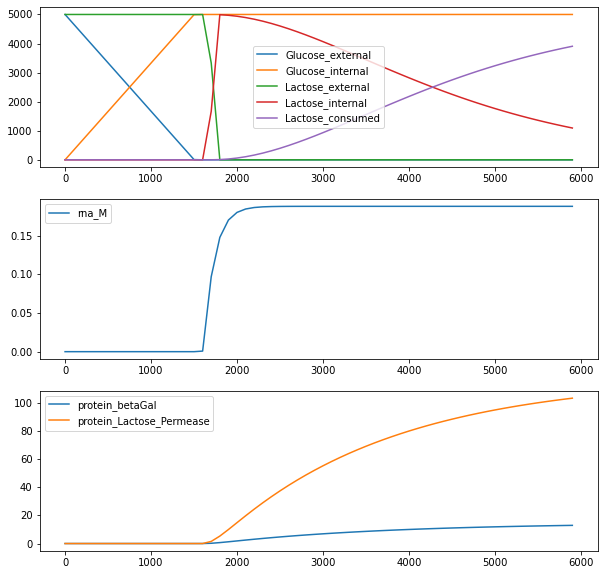

In [2]:
%matplotlib inline
timepoints = np.arange(0, 6000, 100)

#Initial condition requires a small amount of LacP
#x0 = {str(OLac):1, str(L_out):1000, str(G_out):2000, str(lacP):.01}

R = CRN.simulate_with_bioscrape_via_sbml(timepoints)

plt.figure(figsize = (10, 10))
plt.subplot(311)
plt.plot(timepoints, R[str(G_out)], label = str(G_out))
plt.plot(timepoints, R[str(G_in)], label = str(G_in))
#plt.plot(timepoints, R[str(G_consumed)], label = str(G_consumed))
plt.plot(timepoints, R[str(L_out)], label = str(L_out))
plt.plot(timepoints, R[str(L_in)], label = str(L_in))
plt.plot(timepoints, R[str(L_consumed)], label = str(L_consumed))
plt.legend()

plt.subplot(312)
plt.plot(timepoints, R[str(M)], label = str(M))
plt.legend()

plt.subplot(313)
plt.plot(timepoints, R[str(B)], label = str(B))
plt.plot(timepoints, R[str(lacP)], label = str(lacP))
plt.legend()

plt.show()

## Run 10 Stochastic Simulations

Notice that RNA leak (production of a single transcript) produces enough Lactose Permease and $\beat$Gal to intake and metabolize many more lactose molecules than glucose molecules. This suggests that the glucose intake rate is too low.

Running 10 Simulations: 0 1 2 3 4 5 6 7 8 9 

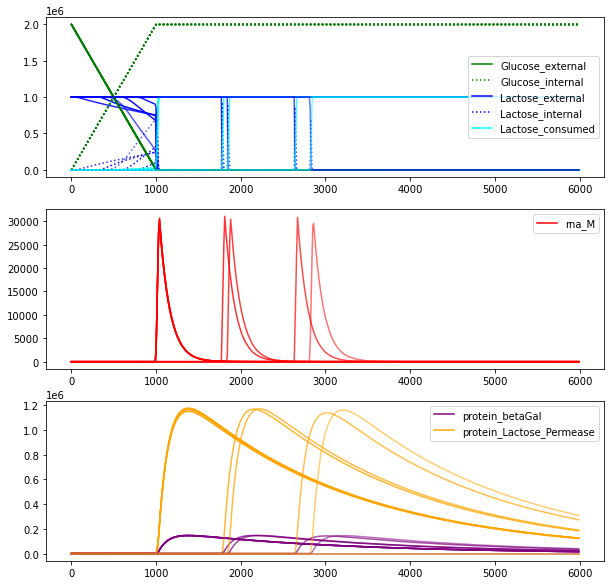

In [3]:
%matplotlib inline
timepoints = np.arange(0, 6000, 10, dtype = np.double)

#Units are counts!
lacP0 = 0 #nonzero so a small amount of lactose can enter the cell
Olac0 = 2 #~= 2 copies of Lac Operon per cell, variable D in Santillan 2007
L_out0 = 1*10**6 #This should change!
G_out0 = 2*10**6 #This should change!
biomass0 = 1 #This should change!
initial_concentration = {lacP:lacP0, BioMass:biomass0, OLac:Olac0, L_out: L_out0, G_out:G_out0}

N_simulations = 10

plt.figure(figsize = (10, 10))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
print("Running", N_simulations, "Simulations:", end = " ")
for i in range(N_simulations):
    print(i, end=" ")
    R = CRN.simulate_with_bioscrape_via_sbml(timepoints, stochastic = True, initial_condition_dict = initial_concentration)
    
    plt.sca(ax1)
    alpha = 1-i/(2*N_simulations)
    plt.plot(timepoints, R[str(G_out)], label = str(G_out), color = "green", alpha = alpha)
    plt.plot(timepoints, R[str(G_in)], ":", label = str(G_in), color = "green", alpha = alpha)
    plt.plot(timepoints, R[str(L_out)], label = str(L_out), color = "blue", alpha = alpha)
    plt.plot(timepoints, R[str(L_in)], ":", label = str(L_in), color = "blue", alpha = alpha)
    plt.plot(timepoints, R[str(L_consumed)], label = str(L_consumed), color = "cyan", alpha = alpha)
    if i == 0:
        plt.legend()

    
    plt.sca(ax2)
    
    plt.plot(timepoints, R[str(M)], label = str(M), color = "red", alpha = alpha)
    if i == 0:
        plt.legend()

    plt.sca(ax3)
    plt.plot(timepoints, R[str(B)], label = str(B), alpha = alpha, color = "purple")
    plt.plot(timepoints, R[str(lacP)], label = str(lacP), alpha = alpha, color = "orange")
    if i == 0:
        plt.legend()

plt.show()